## Current directions on data privacy

Although traditional techniques for de-identification such as perturbative and non-perturbative techniques are well-known and were used for many years, current research point towards synthetic data generation. Its popularity have increased because of its supposed absence of privacy concerns without incurring the issues that come with other PPTs. Synthetic data does not require high expertise in data privacy domain and disclosure risk is very low compared to the remaining PPTs. In this section, you will learn:

- synthetic data principles
- synthetic data generation
- data utility assessment
- re-identification risk assessment

### Data synthetization with GANs

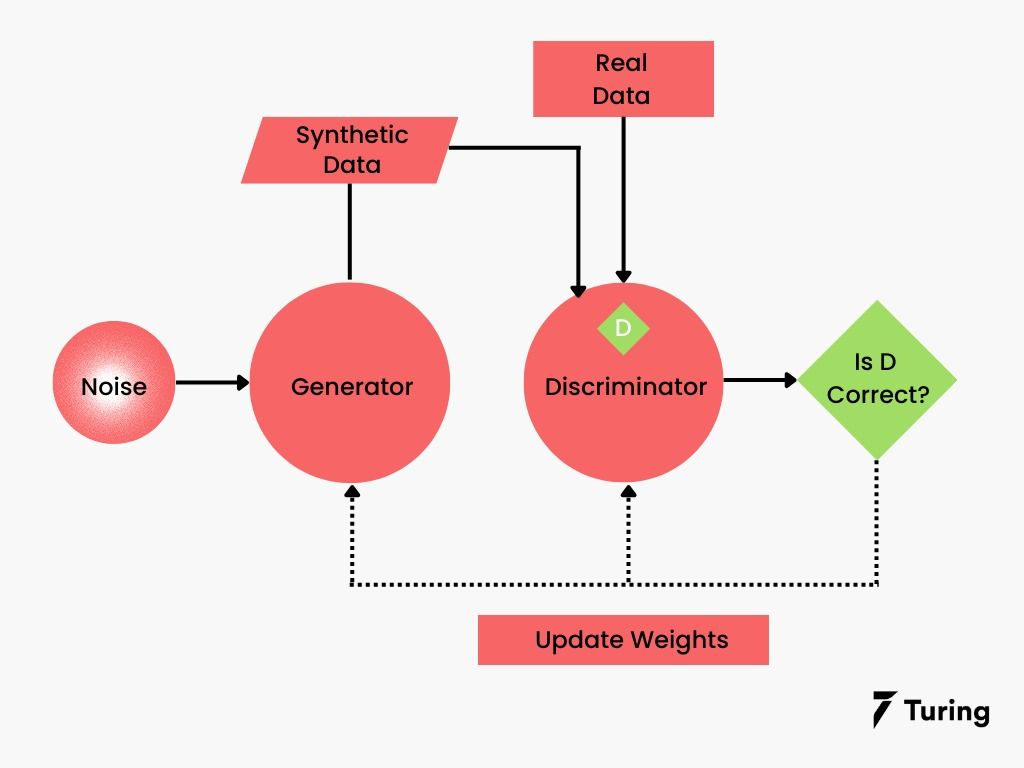

**Generator**: creates realistic synthetic instances until the discriminator can no longer determine is fake.

**Discriminator**: when shown an instance from the true dataset, it recognizes if a generated instance (from the generator) is authentic, and decides whether each instance is real from the training dataset, or fake from the generator.


1️⃣ Noise is fed into the generator;

2️⃣ Training data and the output of the generator is sent to the discriminator, which is being trained in parallel to identify real/fake instances;

3️⃣ The output of the discriminator can be fed back to the generator and the discriminator, which can use this information to update parameters and attempt to improve on the accuracy.

Common synthetization models:
- CopulaGAN
- CTGAN
- TVAE (based on autoencoders)

### Synthetic data generation

For data synthetization I will be using the [SDV - Synthetic Data Vault](https://docs.sdv.dev/sdv/) library, that includes the most known data synthetization methods.

In [70]:
# Import the libraries
import pandas as pd
import random

from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import recordlinkage

import warnings
warnings.filterwarnings('ignore')

In [98]:
# Read data
data = pd.read_csv("students-performance.csv")

In [99]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,class
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,High
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,High
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,High
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,High
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,High


In [100]:
# Get 80% of data to synthetization (the 20% will be used to test the data)
random_idx = random.sample(list(data.index), k=int(0.2*len(data)))

train_data = data.iloc[list(set(data.index)-set(random_idx)), :]
test_data = data.iloc[random_idx, :]

In [101]:
# Automatically detect the metadata (required parameter)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train_data)

In [102]:
# Create the synthesizer
synthesizer = CTGANSynthesizer(
    metadata,
    enforce_rounding=False,
    epochs=200,
    embedding_dim=64,
    batch_size=50,
    verbose=True
)

In [103]:
# Train the synthesizer
synthesizer.fit(train_data)

Epoch 1, Loss G:  0.9808,Loss D: -0.1086
Epoch 2, Loss G:  0.5385,Loss D: -0.1240
Epoch 3, Loss G:  0.0589,Loss D: -0.1484
Epoch 4, Loss G: -0.4941,Loss D:  0.0701
Epoch 5, Loss G: -0.5812,Loss D:  0.3460
Epoch 6, Loss G: -0.4511,Loss D:  0.1675
Epoch 7, Loss G: -0.1612,Loss D: -0.1812
Epoch 8, Loss G: -0.9254,Loss D:  0.2516
Epoch 9, Loss G: -0.3014,Loss D:  0.5155
Epoch 10, Loss G: -0.2315,Loss D: -0.0994
Epoch 11, Loss G: -0.6641,Loss D:  0.5770
Epoch 12, Loss G: -0.2876,Loss D:  0.5304
Epoch 13, Loss G: -0.1066,Loss D: -0.1710
Epoch 14, Loss G: -0.3236,Loss D: -0.4178
Epoch 15, Loss G: -0.4501,Loss D:  0.0241
Epoch 16, Loss G:  0.0302,Loss D:  0.3685
Epoch 17, Loss G:  0.5387,Loss D: -0.2192
Epoch 18, Loss G: -0.1943,Loss D:  0.1603
Epoch 19, Loss G: -0.0391,Loss D:  0.8748
Epoch 20, Loss G: -0.2574,Loss D: -0.1714
Epoch 21, Loss G:  0.0625,Loss D:  0.3479
Epoch 22, Loss G: -0.2732,Loss D:  0.2436
Epoch 23, Loss G:  0.5279,Loss D: -0.1381
Epoch 24, Loss G: -0.5020,Loss D:  0.3355
E

Epoch 195, Loss G: -4.0553,Loss D: -0.2121
Epoch 196, Loss G: -4.8906,Loss D: -0.9790
Epoch 197, Loss G: -5.2808,Loss D: -1.1442
Epoch 198, Loss G: -6.0482,Loss D:  0.3912
Epoch 199, Loss G: -5.6375,Loss D: -0.2802
Epoch 200, Loss G: -5.2767,Loss D: -0.2882


ContextualVersionConflict: (pandas 2.0.1 (/Users/taniacarvalho/.local/share/virtualenvs/hands-on-data-deidentification-2zBriT2y/lib/python3.10/site-packages), Requirement.parse('pandas<2,>=1.5.0; python_version >= "3.10"'), {'sdv'})

In [116]:
# Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=len(train_data))

In [117]:
synthetic_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,class
0,GP,F,17,U,GT3,T,2,1,other,other,...,4,4,3,1,2,5,7,12,19,High
1,GP,F,17,U,LE3,A,3,1,services,services,...,4,4,5,2,1,4,3,11,9,High
2,GP,M,17,R,GT3,T,1,2,other,services,...,4,4,3,1,3,5,0,3,16,High
3,MS,F,17,R,GT3,T,3,2,services,other,...,4,4,3,1,1,5,4,12,17,High
4,MS,F,18,U,LE3,T,1,1,at_home,other,...,3,4,4,5,2,5,2,10,8,High


In [118]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,class
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,High
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,High
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,High
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,High
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,High


### Data utility

In [112]:
def modeling(train_data, test_data):

    # Encode data
    encoded_train_data = pd.get_dummies(train_data, drop_first=True).astype(int)
    encoded_test_data = pd.get_dummies(test_data, drop_first=True).astype(int)
    
    # Split the data into train and test
    X_train, y_train = encoded_train_data.iloc[:, :-1], encoded_train_data.iloc[:, -1]
    X_test, y_test = encoded_test_data.iloc[:, :-1], encoded_test_data.iloc[:, -1]

    # Scale data
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform (X_test)
    
    # Initiate models
    seed = np.random.seed(1234)
    xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)

    # Set parameters
    param_grid_xgb = {
        'n_estimators': [100, 250, 500],
        'max_depth': [4, 6, 8, 10],
        'learning_rate': [0.1, 0.01, 0.001]
    }
    
    # Fit the parameter grid with 5-fold cross validation
    gs_rf = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy').fit(X_train, y_train)
    
    # Predict on test data with best params
    y_pred = gs_rf.predict(X_test)
    
    return y_test, y_pred

In [113]:
# Predict results for original data
y_test, initial_preds = modeling(train_data, test_data)
accuracy_score(y_test, initial_preds)

(520, 41)
(129, 41)
(520,)
(129,)


0.9302325581395349

In [119]:
# Predict results for synthetic data
y_test, synthetic_preds = modeling(synthetic_data, test_data)
accuracy_score(y_test, synthetic_preds)

(520, 41)
(129, 41)
(520,)
(129,)


0.8449612403100775

Percentage difference between the original and the transformed data.

(𝑅𝑎−𝑅𝑏)/𝑅𝑏∗100, where $a$ is the transformed and $b$ is the baseline (original result)

In [120]:
(0.8449612403100775 - 0.9302325581395349) / 0.9302325581395349 *100

-9.166666666666671

### Re-identification risk

In [122]:
def record_linkage(transformed, original, columns):
    """
    transformed (pd.DataFrame): transformed dataframe with singleouts
    original (pd.DataFrame): original dataframe with single outs
    columns (list): list of quasi-identifiers

    Returns:
        pd.Dataframe: comparison results with respective score
    """
    # Calulate the candidates for comparison
    indexer = recordlinkage.Index()
    indexer.full()
    candidates = indexer.index(transformed, original)
    print(len(candidates))
    compare = recordlinkage.Compare(n_jobs=-1)
    
    # Set the distances measures for each column
    for idx, col in enumerate(columns):
        if col in transformed.columns:
            if transformed[col].dtype == 'object':
                original[col] = original[col].astype(str)
                compare.string(col, columns[idx], label=columns[idx], method='levenshtein', threshold=0.7)    
            else:
                compare.numeric(col, columns[idx], label=columns[idx], method='gauss')
    
    # Compute the distances
    comparisons = compare.compute(candidates, transformed, original)
    # Filter the scores: >= 50% of matches
    potential_matches = comparisons[comparisons.sum(axis=1) > 1].reset_index()
    potential_matches['Score'] = potential_matches.iloc[:, 2:].sum(axis=1)
    potential_matches = potential_matches[potential_matches['Score'] >= \
        0.5*potential_matches['Score'].max()]
    
    return potential_matches

In [123]:
potential_matches = record_linkage(synthetic_data, train_data, ['age', 'sex', 'address', 'Mjob'])

270400


In [125]:
potential_matches.head()

,level_0,level_1,age,sex,address,Mjob,Score
0,0,0,0.5000,1.0,1.0,0.0,2.5000
1,0,1,1.0000,1.0,1.0,0.0,3.0000
2,0,2,0.0625,1.0,1.0,0.0,2.0625
3,0,3,0.0625,1.0,1.0,0.0,2.0625
4,0,4,0.5000,1.0,1.0,1.0,3.5000


In [148]:
def thr_matches(potential_matches, thr):
    """
    potential_matches (pd.DataFrame): potential matches
    thr (list of integers): threshold interval for matches

    Returns:
        pd.Dataframe: comparison results with respective score
    """
    # Get the potential matches for a specific threshold
    if len(thr) > 1:
        acceptable_score = potential_matches[(potential_matches['Score'] >= \
            thr[0]*potential_matches['Score'].max()) & (potential_matches['Score'] < \
            thr[1]*potential_matches['Score'].max())]
    else: 
        acceptable_score = potential_matches[(potential_matches['Score'] == potential_matches['Score'].max())]

    # Group by original index to find the unique matches
    acceptable_score_uniques = acceptable_score.groupby(['level_1']).size()

    return acceptable_score_uniques

\begin{equation}
\textit{RIRisk}_{thr \in \delta} = \begin{cases}
     \frac{\frac{1}{min(\omega)} * 100}{\#instances}, if \delta \in \{0.5, 0.7, 0.9\}.\\ \\
     \frac{\upsilon * 100}{\#instances}, if \delta = 1.
    \end{cases}
\end{equation}

In [149]:
thr50 = thr_matches(potential_matches, [0.5, 0.7])
((1/thr50.min()) * 100) / len(train_data)

0.0031017369727047144

In [150]:
thr70 = thr_matches(potential_matches, [0.7, 0.8])
((1/thr70.min()) * 100) / len(train_data)

0.0641025641025641

In [151]:
thr80 = thr_matches(potential_matches, [0.8, 0.9])
((1/thr80.min()) * 100) / len(train_data)

0.19230769230769232

In [152]:
thr90 = thr_matches(potential_matches, [0.9, 1])
((1/thr90.min()) * 100) / len(train_data)

nan

In [153]:
thr100 = thr_matches(potential_matches, [1])
(len(thr100[thr100==1]) * 100) / len(train_data)

9.615384615384615

In [167]:
acceptable_score = potential_matches[(potential_matches['Score'] == potential_matches['Score'].max())]
# Group by original index to find the unique matches
acceptable_score.loc[(acceptable_score.groupby(['level_0', 'level_1']).transform('size')==1)]

,level_0,level_1,age,sex,address,Mjob,Score
16401,37,268,1.0,1.0,1.0,1.0,4.0
22144,50,268,1.0,1.0,1.0,1.0,4.0
26878,61,268,1.0,1.0,1.0,1.0,4.0
63701,143,543,1.0,1.0,1.0,1.0,4.0
84536,190,448,1.0,1.0,1.0,1.0,4.0
110300,247,446,1.0,1.0,1.0,1.0,4.0
115053,258,268,1.0,1.0,1.0,1.0,4.0
116356,261,433,1.0,1.0,1.0,1.0,4.0
169761,380,268,1.0,1.0,1.0,1.0,4.0
193884,432,446,1.0,1.0,1.0,1.0,4.0


In [278]:
# save the transformed data
# data.to_csv('output/2anonymous_students.csv', index=False)

### Additional notes

- Sampling methods are also used for synthesization - they usually require less time to generate new data than GAN and are based on nearest neighbor algorithms;
- Synthetic data also has an underlying privacy risk, namely, outliers are very likely to be identifiable since the synthetic data follows the original distribution. Furthermore, in the training process, an intruder can infer whether an individual is part of the training data (**membership attacks**);
- Synthetic data models typically better capture the distribution of data in larger data sets.
- Record linkage is computationally costly;

**Available tools for data de-identification**

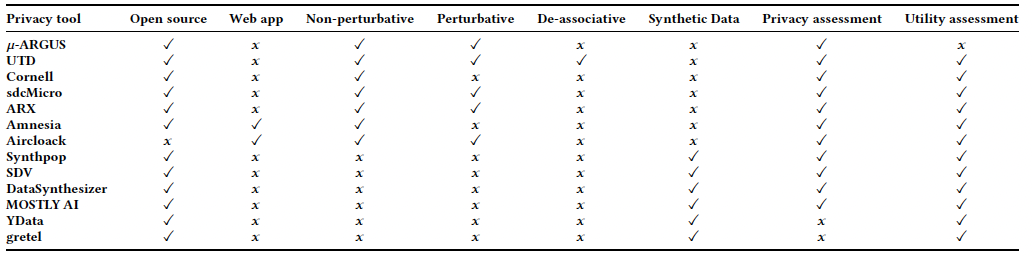